## Start off with key imports and enforcement of rcparams

In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import os
import pathlib
from glob import glob
from astropy.table import Table, unique
from scipy.fft import fft, ifft
from IPython.display import display, Math, Markdown
from cmath import exp, pi
from astropy.io import ascii
from scipy.optimize import curve_fit, minimize

os.chdir(pathlib.Path.cwd())
def set_rcparams():
    tab = Table.read('../../rcparams.txt', format='csv')
    for i in range(len(tab)):
        try:
            plt.rcParams[tab['key'][i]] = float(tab['val'][i])
        except ValueError:
            plt.rcParams[tab['key'][i]] = str(tab['val'][i])
    return
set_rcparams()
#plt.style.use('dark_background')

In [2]:
stella_data = pd.read_csv('/Users/mschochet/Documents/GitHub/aumic_2025a/data_analysis/tess/stella_lc.csv')
stella_lc = lk.LightCurve(flux=stella_data['flux'], time=stella_data['time'], flux_err=stella_data['flux_err'])#.normalize()

with open('stella_probabilities.npy', 'rb') as f:
    avg_pred = np.load(f)

stella_lc.add_column(avg_pred, name='stella_prob'
                     )
# Now we'll fold it and write it into continuous arrays for the FFT
stella_lc_folded = stella_lc.copy().fold(4.86, epoch_time=2400000, epoch_phase=3)
x = np.ascontiguousarray(stella_lc_folded.time.value, dtype=np.float64)
y = np.ascontiguousarray(stella_lc_folded.flux, dtype=np.float64)
yerr_scaled = np.ascontiguousarray(stella_lc_folded.flux_err * stella_lc_folded['stella_prob'], dtype=np.float64)
yerr = np.ascontiguousarray(stella_lc_folded.flux_err, dtype=np.float64)

stella_lc_og = stella_lc.copy()
x_og = np.ascontiguousarray(stella_lc_og.time.value, dtype=np.float64)
y_og = np.ascontiguousarray(stella_lc_og.flux, dtype=np.float64)
yerr_og_scaled = np.ascontiguousarray(stella_lc_og.flux_err * stella_lc_og['stella_prob'], dtype=np.float64)
yerr_og_not = np.ascontiguousarray(stella_lc_og.flux_err, dtype=np.float64)


In [3]:
p02 = [np.pi/70, np.max(y) - np.min(y), 3, np.max(y), (np.max(y) - np.min(y))/2, 3, np.max(y)]
p03 = [np.pi/70, np.max(y) - np.min(y), 3, np.max(y), (np.max(y) - np.min(y))/2, 3, np.max(y),(np.max(y) - np.min(y))/4, 3, np.max(y)]

def model_sine2(X, omega, amp, phase, offset1, amp2, phase2, offset2):
    return amp * np.sin(omega * X + phase) + offset1 + amp2 * np.sin(omega/2 * X + phase2) + offset2


def model_sine3(X, omega, amp, phase, offset1, amp2, phase2, offset2, amp3, phase3, offset3):
    return amp * np.sin(omega * X + phase) + offset1 + amp2 * np.sin(omega/2 * X + phase2) + offset2 + amp3 * np.sin(omega/4 * X + phase3) + offset3

poptsin2, pcovsine2 = curve_fit(model_sine2, x.tolist(), y,
                  p0=p02,
                  maxfev=50000)

poptsin3, pcovsine3 = curve_fit(model_sine3, x.tolist(), y,
                                p0=p03,
                                maxfev=100000)


Parameters for 2-sine fit are:
 ω=2.5871429 
 (sin of f) A1=0.01029289, φ1=6.90821119, C1=-3.04507849 
 (sin of f/2) A2=0.04442909, φ2=4.81237698, C2=4.04248481
Functional form of 2-sine fit is:
 Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2



Parameters for 3-sine fit are:
 ω=2.4902676 
 (sin of f) A1=-0.01145925, φ1=10.04718015, C1=0.29327355 
 (sin of f/2) A2=-0.05476631, φ2=7.88085474, C2=0.34574515 
 (sin of f/5) A3=0.02198520, φ3=14.00346708, C3=0.34637851
Functional form of 3-sine fit is:
 Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2 + A3*sin(ω/5*t + φ3) + C3


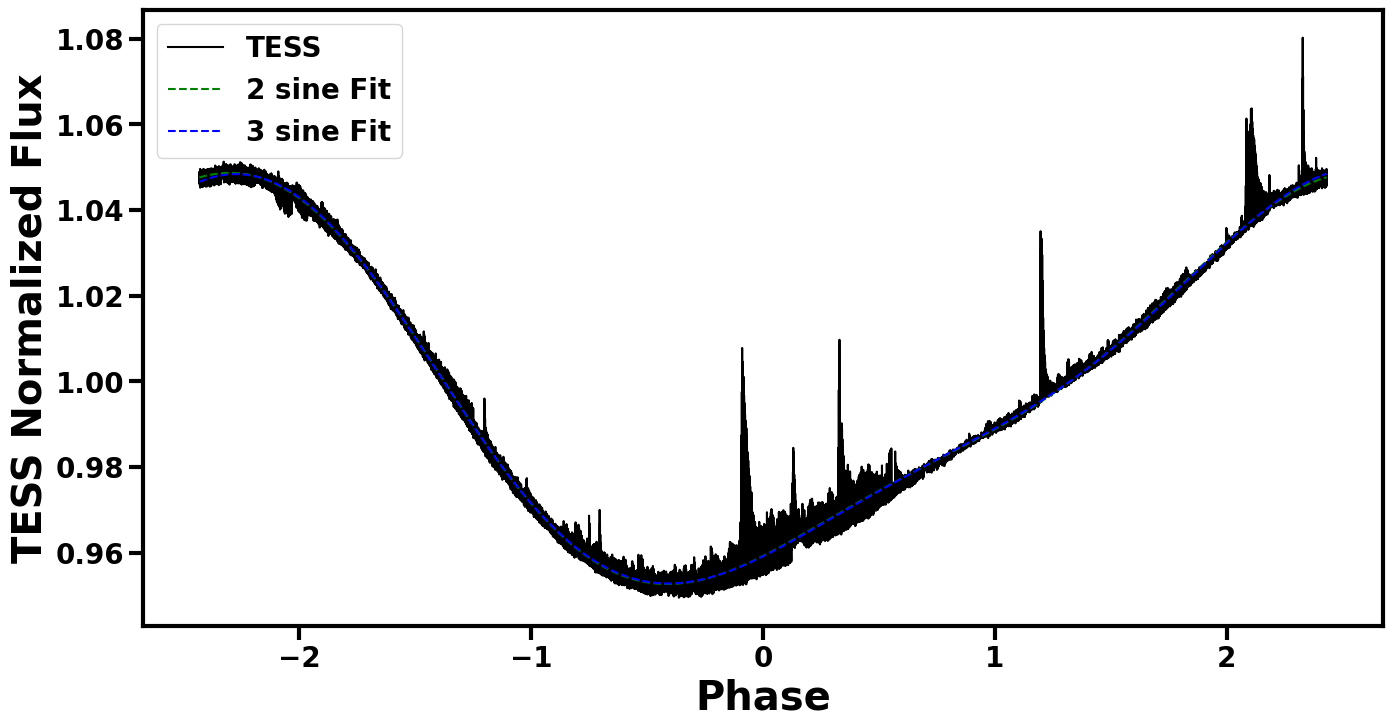

In [4]:
afig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 1, 1)
ax.plot(x, y, label='TESS', color='k')
ax.plot(x, model_sine2(x, *poptsin2), 'g--', label='2 sine Fit')
ax.plot(x, model_sine3(x, *poptsin3), 'b--', label='3 sine Fit')

print('Parameters for 2-sine fit are:\n ω={:.8} \n (sin of f) A1={:.8f}, φ1={:.8f}, C1={:.8f} \n (sin of f/2) A2={:.8f}, φ2={:.8f}, C2={:.8f}'.format(*poptsin2))
print('Functional form of 2-sine fit is:\n Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2')

print('\n\n\nParameters for 3-sine fit are:\n ω={:.8} \n (sin of f) A1={:.8f}, φ1={:.8f}, C1={:.8f} \n (sin of f/2) A2={:.8f}, φ2={:.8f}, C2={:.8f} \n (sin of f/5) A3={:.8f}, φ3={:.8f}, C3={:.8f}'.format(*poptsin3))
print('Functional form of 3-sine fit is:\n Flux = A1*sin(ω*t + φ1) + C1 + A2*sin(ω/2*t + φ2) + C2 + A3*sin(ω/5*t + φ3) + C3')
ax.set_ylabel('TESS Normalized Flux')
ax.set_xlabel('Phase')
ax.legend(markerscale=10)#, bbox_to_anchor=(1.01, .95))

In [5]:
def chisq_2(popt, x, y, yerr):
    model = model_sine2(x, *popt)
    chisq = np.sum(((y - model)**2/yerr**2))
    return chisq

In [6]:
def chisq_3(popt, x, y, yerr):
    model = model_sine3(x, *popt)
    chisq = np.sum(((y - model)**2/yerr**2))
    return chisq

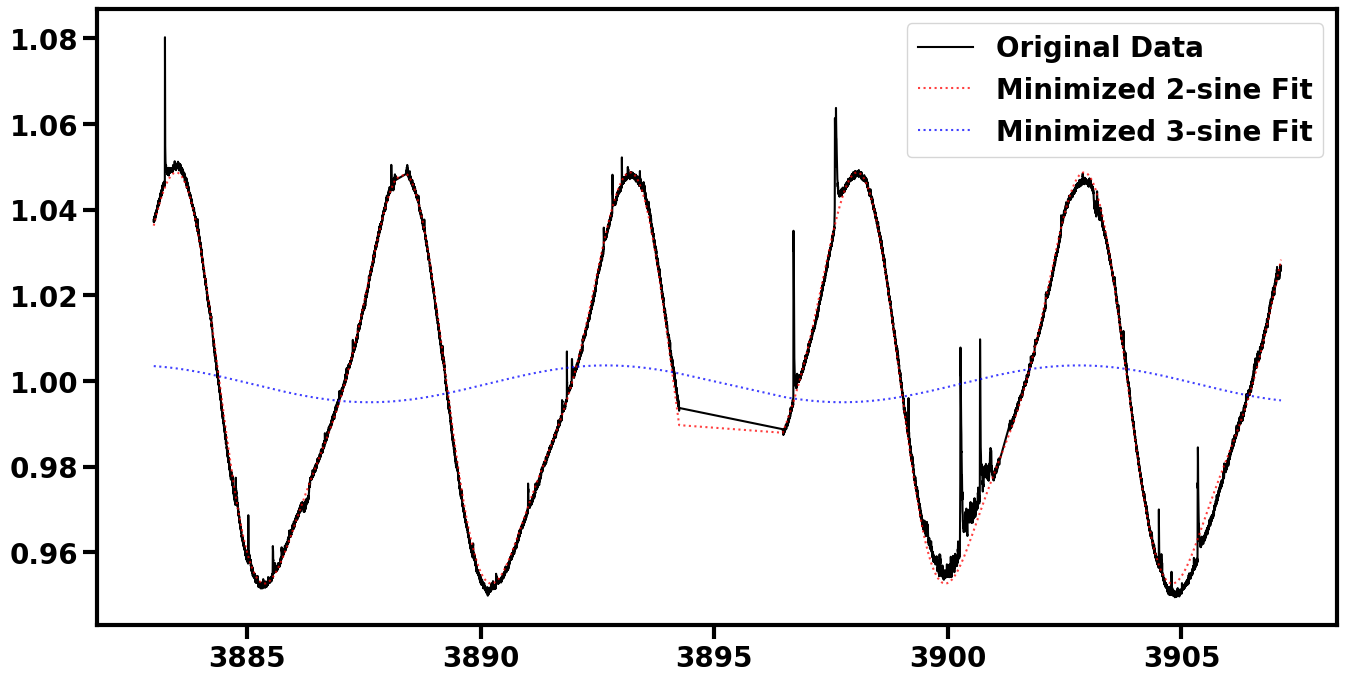

In [8]:
## Minmized, all curvefit parameters, not-scaled errors (T1)
fitter_2  = minimize(fun=chisq_2, x0 = (poptsin2[0], poptsin2[1], poptsin2[2], poptsin2[3], poptsin2[4], poptsin2[5], poptsin2[6]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (poptsin3[0], poptsin3[1], poptsin3[2], poptsin3[3], poptsin3[4], poptsin3[5], poptsin3[6], poptsin3[7], poptsin3[8], poptsin3[9]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

In [112]:
fitter_2

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.221208640690534e-05
        x: [ 2.587e+00  1.029e-02  6.908e+00 -3.045e+00  4.443e-02
             4.812e+00  4.042e+00]
      nit: 3
      jac: [-5.795e-05  2.344e-05 -6.924e-07 -5.001e-05 -6.231e-05
             1.048e-06 -5.001e-05]
     nfev: 56
     njev: 7
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

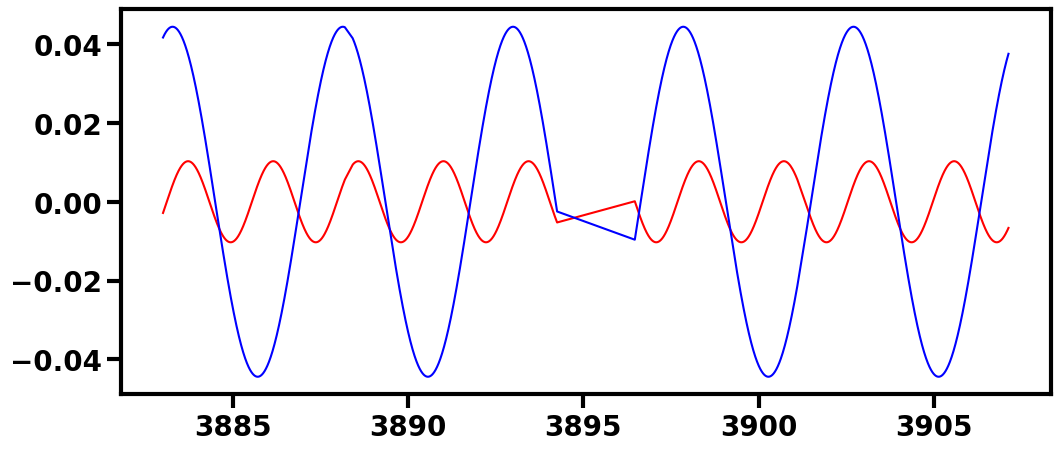

In [116]:
xes = np.linspace(-1, 1, 1000)
def func1(xes):
    return fitter_2.x[1] * np.sin(fitter_2.x[0] * xes + fitter_2.x[2])  
def func2(xes):
    return fitter_2.x[4] * np.sin(fitter_2.x[0]/2 * xes + fitter_2.x[5]) 


fig, ax = plt.subplots (1, 1, figsize=(12, 5))
ax.plot(x_og, func1(x_og), 'r-', label='Primary Sine Component')
ax.plot(x_og, func2(x_og), 'b-', label='Secondary Sine Component')

In [ ]:
P = np.pi*2/fitter_2.x[]
P

np.float64(2.428615804910909)

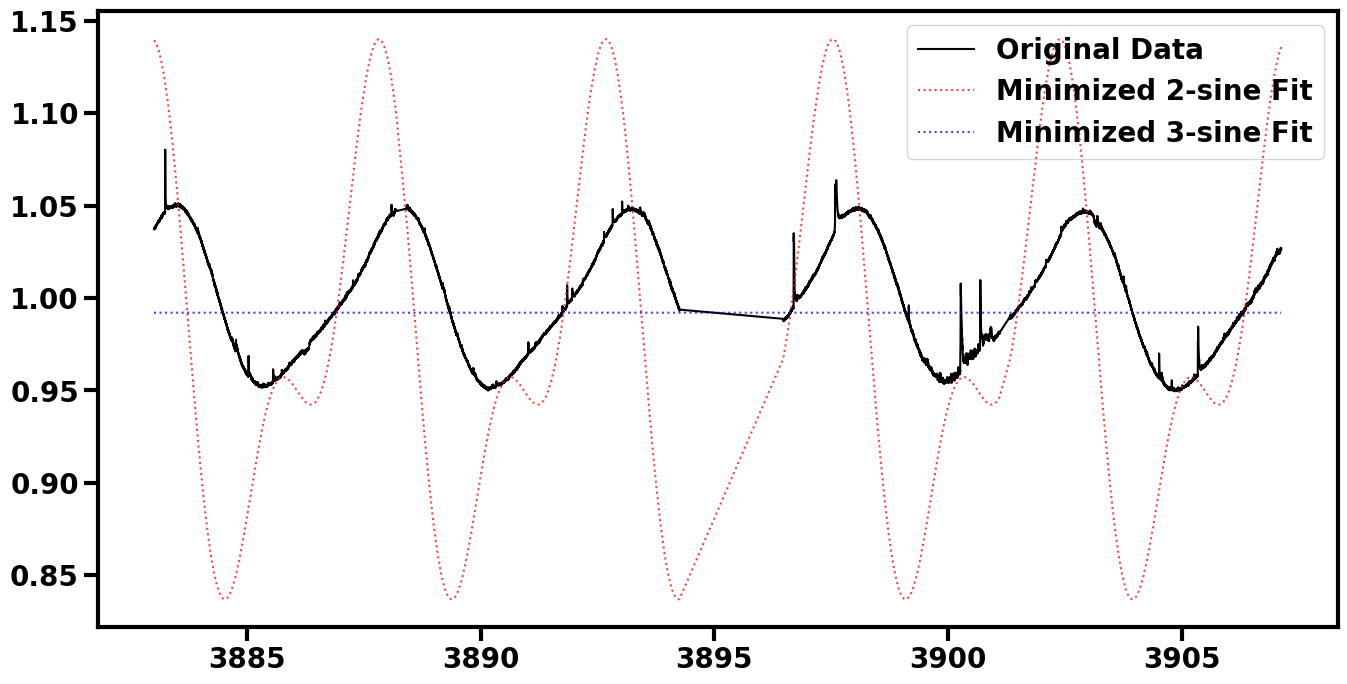

In [100]:
## Minmized, all curvefit parameters, scaled errors (T2)
fitter_2  = minimize(fun=chisq_2, x0 = (poptsin2[0], poptsin2[1], poptsin2[2], poptsin2[3], poptsin2[4], poptsin2[5], poptsin2[6]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (poptsin3[0], poptsin3[1], poptsin3[2], poptsin3[3], poptsin3[4], poptsin3[5], poptsin3[6], poptsin3[7], poptsin3[8], poptsin3[9]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

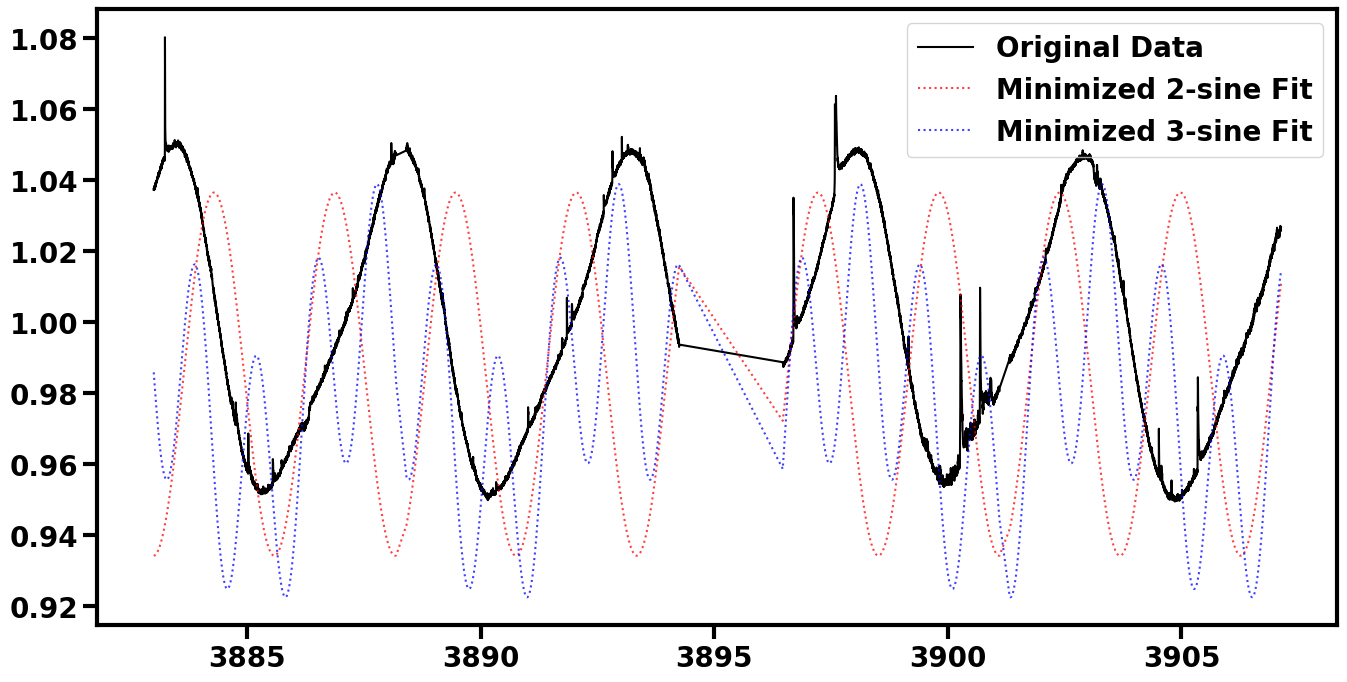

In [67]:
## Minmized, all curvefit parameters except omega, scaled errors (T3)
fitter_2  = minimize(fun=chisq_2, x0 = (4.86, poptsin2[1], poptsin2[2], poptsin2[3], poptsin2[4], poptsin2[5], poptsin2[6]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (4.86, poptsin3[1], poptsin3[2], poptsin3[3], poptsin3[4], poptsin3[5], poptsin3[6], poptsin3[7], poptsin3[8], poptsin3[9]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

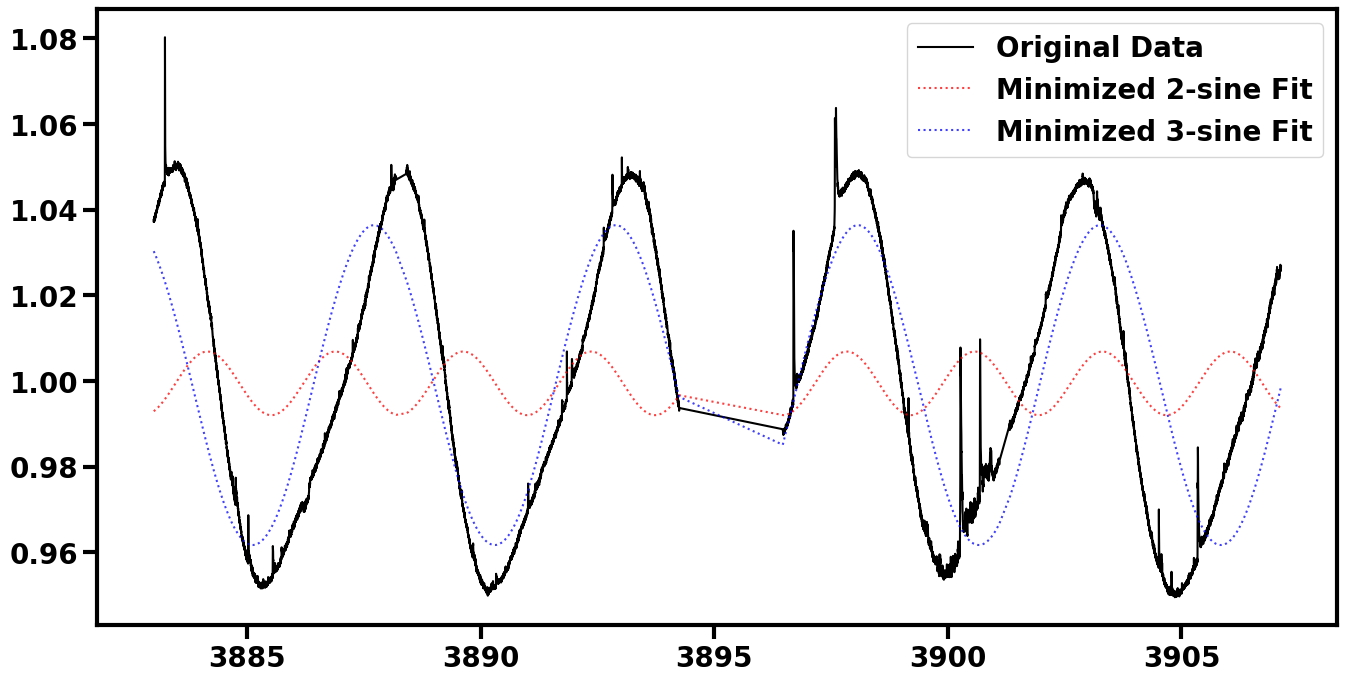

In [70]:
## Minmized, all curvefit parameters except omega, scaled errors (T4)
fitter_2  = minimize(fun=chisq_2, x0 = (4.86, poptsin2[1], poptsin2[2], poptsin2[3], poptsin2[4], poptsin2[5], poptsin2[6]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), method='L-BFGS-B', options={'maxiter':100000})

fitter_3  = minimize(fun=chisq_3, x0 = (4.86, poptsin3[1], poptsin3[2], poptsin3[3], poptsin3[4], poptsin3[5], poptsin3[6], poptsin3[7], poptsin3[8], poptsin3[9]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10), (0, 1), (-10, 10), (-10, 10)), method='L-BFGS-B', options={'maxiter':100000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

## NOW THE SINES HAVE DIFF OMEGAS

In [84]:
p02 = [np.pi/70, np.max(y) - np.min(y), 3, np.max(y), np.pi/70, (np.max(y) - np.min(y))/2, 3, np.max(y)]
p03 = [np.pi/70, np.max(y) - np.min(y), 3, np.max(y), np.pi/70,(np.max(y) - np.min(y))/2, 3, np.max(y), np.pi/70,(np.max(y) - np.min(y))/4, 3, np.max(y)]

def model_sine2(X, omega1, amp, phase, offset1, omega2, amp2, phase2, offset2):
    return amp * np.sin(omega1 * X + phase) + offset1 + amp2 * np.sin(omega2 * X + phase2) + offset2


def model_sine3(X, omega1, amp, phase, offset1, omega2, amp2, phase2, offset2, omega3, amp3, phase3, offset3):
    return amp * np.sin(omega1 * X + phase) + offset1 + amp2 * np.sin(omega2 * X + phase2) + offset2 + amp3 * np.sin(omega3 * X + phase3) + offset3

poptsin2a, pcovsine2a = curve_fit(model_sine2, x.tolist(), y,
                  p0=p02,
                  maxfev=50000)

poptsin3a, pcovsine3a = curve_fit(model_sine3, x.tolist(), y,
                                p0=p03,
                                maxfev=100000)


Parameters for 2-sine fit are:
 ω1=1.2846286 
 (sin of f) A1=0.04456209, φ1=4.81215871, C1=0.88004537 
 (sin of f/2) ω2=2.5909866 A2=-0.01021287, φ2=3.74683368, C2=0.11766219
Functional form of 2-sine fit is:
 Flux = A1*sin(ω1*t + φ1) + C1 + A2*sin(ω3*t + φ2) + C2



Parameters for 3-sine fit are:
 ω=-0.0017145342 
 (sin of f) A1=1.02941975, φ1=3.85943312, C1=0.55788001 
 (sin of f/2) ω2=1.3275171, A2=0.04443997, φ2=4.75529389, C2=0.55788001 
 (sin of f/5) ω3=2.4920015, A3=-0.01157442, φ3=3.79214986, C3=0.55788002
Functional form of 3-sine fit is:
 Flux = A1*sin(ω1*t + φ1) + C1 + A2*sin(ω2*t + φ2) + C2 + A3*sin(ω3*t + φ3) + C3


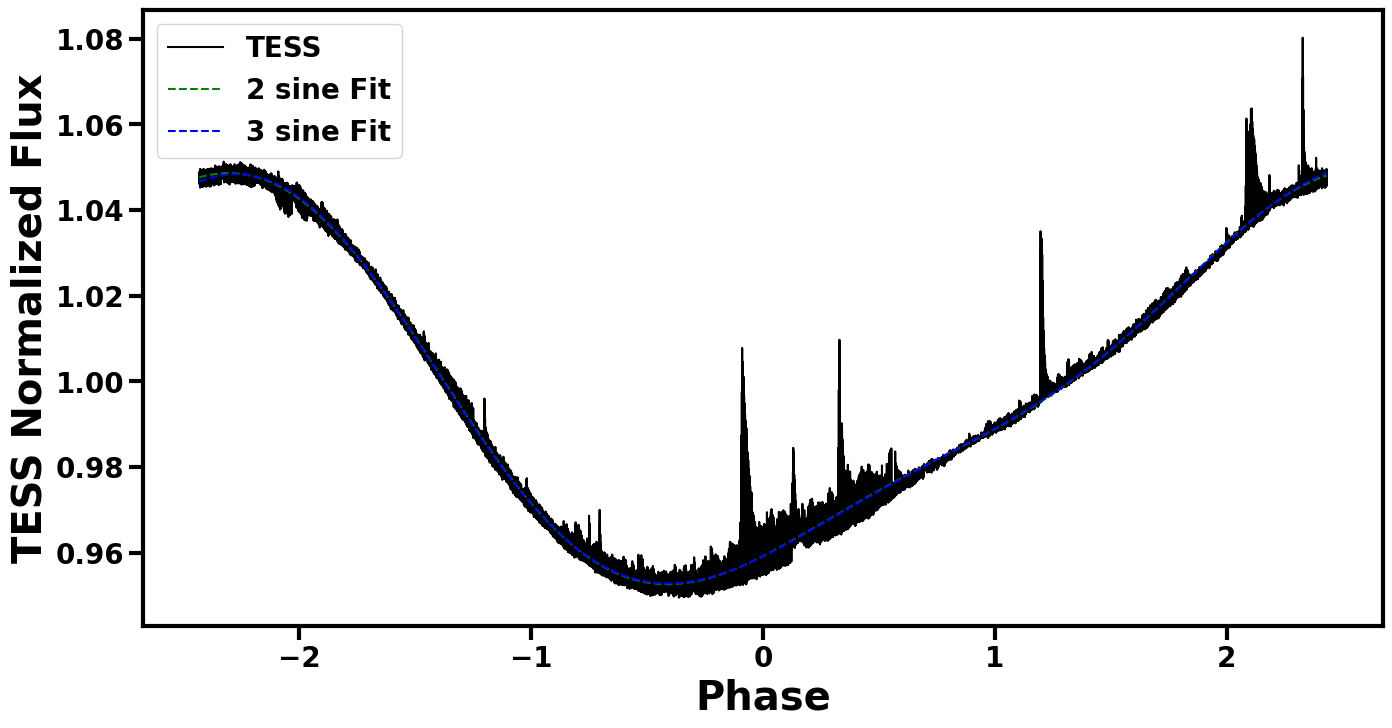

In [85]:
afig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 1, 1)
ax.plot(x, y, label='TESS', color='k')
ax.plot(x, model_sine2(x, *poptsin2a), 'g--', label='2 sine Fit')
ax.plot(x, model_sine3(x, *poptsin3a), 'b--', label='3 sine Fit')

print('Parameters for 2-sine fit are:\n ω1={:.8} \n (sin of f) A1={:.8f}, φ1={:.8f}, C1={:.8f} \n (sin of f/2) ω2={:.8} A2={:.8f}, φ2={:.8f}, C2={:.8f}'.format(*poptsin2a))
print('Functional form of 2-sine fit is:\n Flux = A1*sin(ω1*t + φ1) + C1 + A2*sin(ω3*t + φ2) + C2')

print('\n\n\nParameters for 3-sine fit are:\n ω={:.8} \n (sin of f) A1={:.8f}, φ1={:.8f}, C1={:.8f} \n (sin of f/2) ω2={:.8}, A2={:.8f}, φ2={:.8f}, C2={:.8f} \n (sin of f/5) ω3={:.8}, A3={:.8f}, φ3={:.8f}, C3={:.8f}'.format(*poptsin3a))
print('Functional form of 3-sine fit is:\n Flux = A1*sin(ω1*t + φ1) + C1 + A2*sin(ω2*t + φ2) + C2 + A3*sin(ω3*t + φ3) + C3')
ax.set_ylabel('TESS Normalized Flux')
ax.set_xlabel('Phase')
ax.legend(markerscale=10)#, bbox_to_anchor=(1.01, .95))

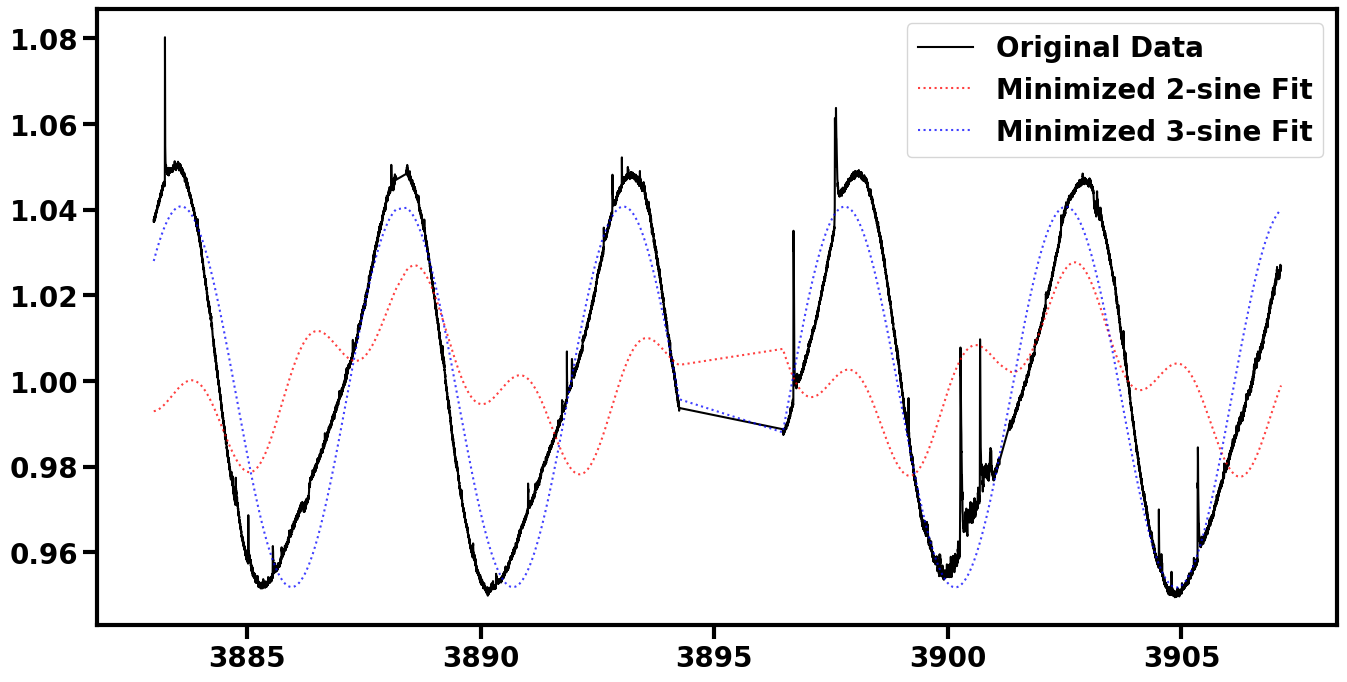

In [86]:
## Minmized, all curvefit parameters, not-scaled errors
fitter_2  = minimize(fun=chisq_2, x0 = (poptsin2a[0], poptsin2a[1], poptsin2a[2], poptsin2a[3], poptsin2a[4], poptsin2a[5], poptsin2a[6], poptsin2a[7]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (poptsin3a[0], poptsin3a[1], poptsin3a[2], poptsin3a[3], poptsin3a[4], poptsin3a[5], poptsin3a[6], poptsin3a[7], poptsin3a[8], poptsin3a[9], poptsin3a[10], poptsin3a[11]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

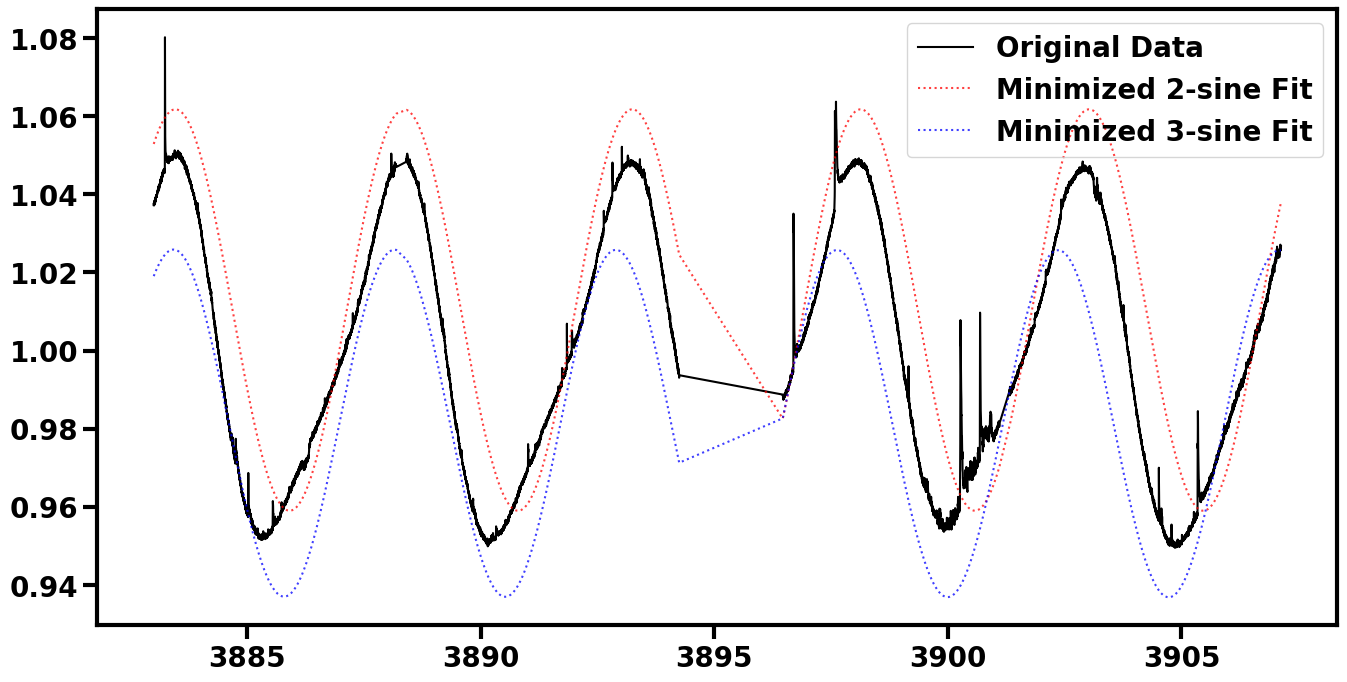

In [88]:
## Minmized, all curvefit parameters, scaled errors
fitter_2  = minimize(fun=chisq_2, x0 = (poptsin2a[0], poptsin2a[1], poptsin2a[2], poptsin2a[3], poptsin2a[4], poptsin2a[5], poptsin2a[6], poptsin2a[7]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (poptsin3a[0], poptsin3a[1], poptsin3a[2], poptsin3a[3], poptsin3a[4], poptsin3a[5], poptsin3a[6], poptsin3a[7], poptsin3a[8], poptsin3a[9], poptsin3a[10], poptsin3a[11]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

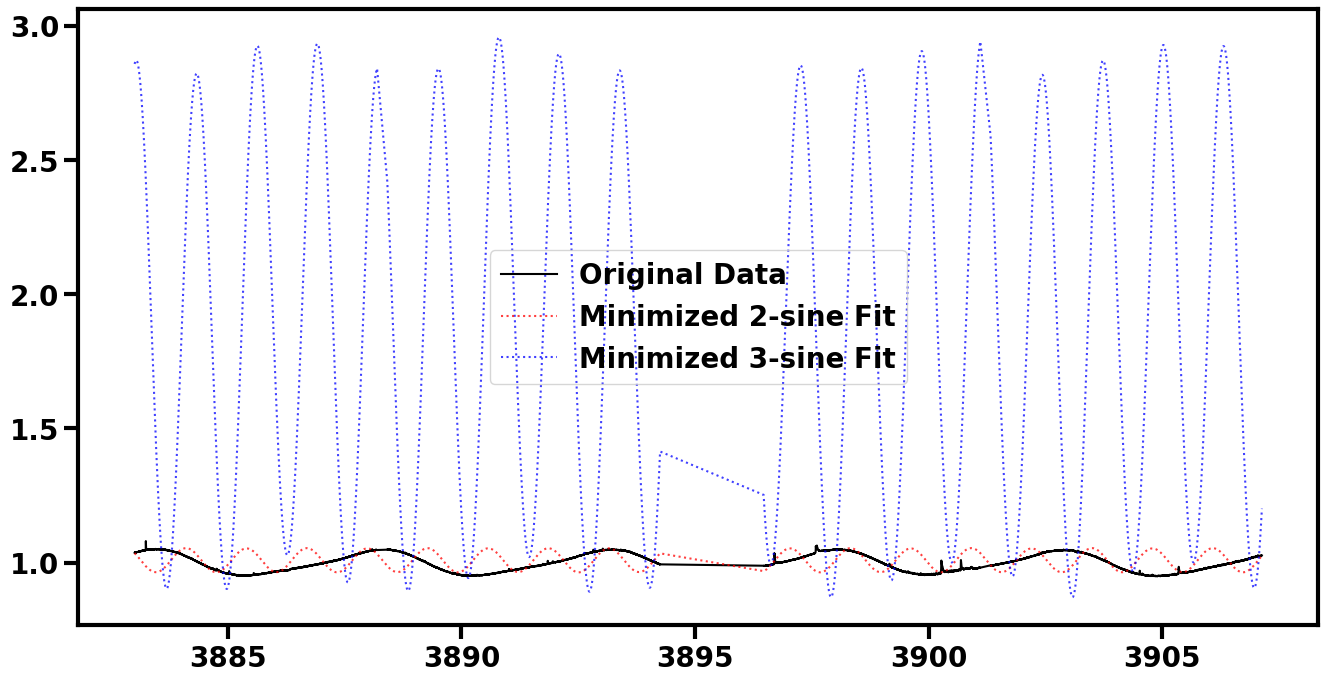

In [89]:
## Minmized, all curvefit parameters (EXCEPT OMEGAS), scaled errors
fitter_2  = minimize(fun=chisq_2, x0 = (4.86, poptsin2a[1], poptsin2a[2], poptsin2a[3], poptsin2a[4], poptsin2a[5], poptsin2a[6], poptsin2a[7]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (4.86, poptsin3a[1], poptsin3a[2], poptsin3a[3], poptsin3a[4], poptsin3a[5], poptsin3a[6], poptsin3a[7], poptsin3a[8], poptsin3a[9], poptsin3a[10], poptsin3a[11]), args=(x_og, y_og, yerr_og_scaled), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()

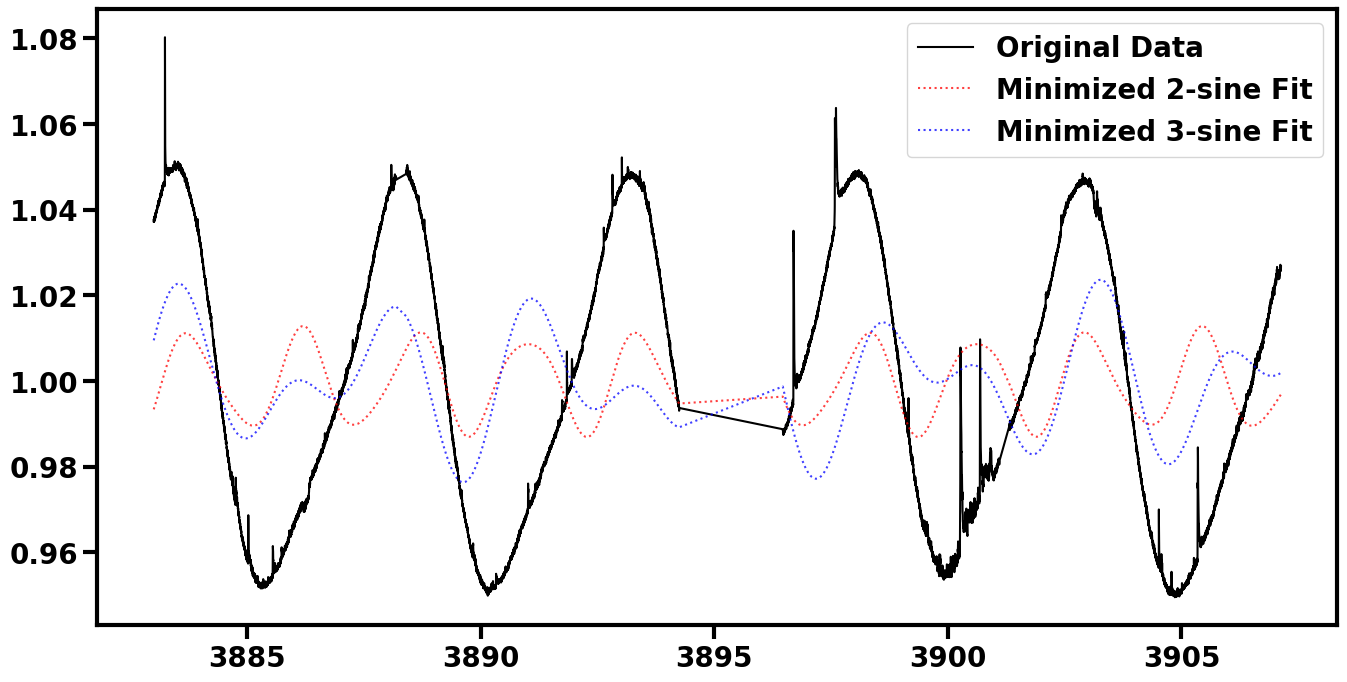

In [93]:
## Minmized, all curvefit parameters (EXCEPT OMEGAS), not-scaled errors
fitter_2  = minimize(fun=chisq_2, x0 = (4.86, poptsin2a[1], poptsin2a[2], poptsin2a[3], poptsin2a[4], poptsin2a[5], poptsin2a[6], poptsin2a[7]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

fitter_3  = minimize(fun=chisq_3, x0 = (4.86, poptsin3a[1], poptsin3a[2], poptsin3a[3], poptsin3a[4], poptsin3a[5], poptsin3a[6], poptsin3a[7], poptsin3a[8], poptsin3a[9], poptsin3a[10], poptsin3a[11]), args=(x_og, y_og, yerr_og_not), 
                     bounds=((0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10), (0, 8), (0, 1), (-10, 10), (-10, 10)), options={'maxiter':10000})

afig = plt.figure(figsize=(16, 8))
afig.set_facecolor('w')
ax = plt.subplot(1, 1, 1)

ax.plot(x_og, y_og, label='Original Data', color='k')
ax.plot(x_og, model_sine2(x_og, *fitter_2.x), 'r:', alpha=0.75, label='Minimized 2-sine Fit')
ax.plot(x_og, model_sine3(x_og, *fitter_3.x), 'b:', alpha=0.75, label='Minimized 3-sine Fit')

ax.legend()